# Passo 2: Análise Exploratória Geral (Descriptive Analytics)

## Objetivo
Este notebook tem como foco a análise descritiva dos dados de varejo. Antes de entrarmos em análises complexas de elasticidade e causalidade, precisamos entender:
1.  **Quem são os campeões de vendas?** (Pareto: Receita e Volume)
2.  **Como as vendas se comportam ao longo do tempo?** (Sazonalidade e Tendência Geral)
3.  **Qual a distribuição de preços e categorias?**
4.  **Qualidade dos dados** (visão geral das distribuições).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Cores Premium
COLORS = ['#2E86C1', '#28B463', '#E74C3C', '#F1C40F', '#8E44AD']

## 1. Carregamento e Visão Geral

In [2]:
# [AUTO-UPDATED] Load from Spark Table
from pyspark.sql import SparkSession
import pandas as pd
import os

# Initialize Spark
spark = SparkSession.builder.appName("EDA").config("spark.sql.warehouse.dir", "spark-warehouse").getOrCreate()

# Load from Table
try:
    df = spark.table("retail_price_clean").toPandas()
    print("Loaded from Spark Table via Hive Metastore.")
except Exception as e:
    print(f"Warning: Could not load from Spark table ({e}). Fallback to parquet.")
    df = pd.read_parquet('../data/retail_price_clean.parquet')

# Carregar dados (formato Parquet otimizado)

# Garantir tipos de data
df['date'] = pd.to_datetime(df['date'])

print(f"Dimensões do Dataset: {df.shape}")
display(df.head())

Dimensões do Dataset: (676, 31)


,product_id,product_category_name,month_year,qty,total_revenue,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,date
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.10,45.95,39,161,2,...,3.90,15.01,215.00,4.40,8.76,45.95,4.00,15.10,45.90,2017-05-01
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.93,45.95,39,161,2,...,3.90,14.77,209.00,4.40,21.32,45.95,4.00,12.93,45.95,2017-06-01
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.84,45.95,39,161,2,...,3.90,13.99,205.00,4.40,22.20,45.95,4.00,14.84,45.95,2017-07-01
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.29,45.95,39,161,2,...,3.90,14.66,199.51,4.40,19.41,45.95,4.00,14.29,45.95,2017-08-01
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.10,45.95,39,161,2,...,3.90,18.78,163.40,4.40,24.32,45.95,4.00,15.10,45.95,2017-09-01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   product_id                  676 non-null    category      
 1   product_category_name       676 non-null    category      
 2   month_year                  676 non-null    object        
 3   qty                         676 non-null    int64         
 4   total_revenue               676 non-null    float64       
 5   freight_price               676 non-null    float64       
 6   unit_price                  676 non-null    float64       
 7   product_name_lenght         676 non-null    int64         
 8   product_description_lenght  676 non-null    int64         
 9   product_photos_qty          676 non-null    int64         
 10  product_weight_g            676 non-null    int64         
 11  product_score               676 non-null    float64       

In [4]:
display(df.describe())

,qty,total_revenue,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,...,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,date
count,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,...,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676
mean,14.50,1422.71,20.68,106.50,48.72,767.40,1.99,1847.50,4.09,81.03,...,4.16,18.60,92.93,4.12,18.62,84.18,4.00,17.97,107.40,2017-12-15 17:47:13.136094720
min,1.00,19.90,0.00,19.90,29.00,100.00,1.00,100.00,3.30,1.00,...,3.70,0.10,19.90,3.30,4.41,19.90,3.50,7.67,19.85,2017-01-01 00:00:00
25%,4.00,333.70,14.76,53.90,40.00,339.00,1.00,348.00,3.90,34.00,...,4.10,13.83,53.90,4.10,14.48,53.79,3.90,15.04,55.67,2017-09-01 00:00:00
50%,10.00,807.89,17.52,89.90,51.00,501.00,1.50,950.00,4.10,62.00,...,4.20,16.62,89.99,4.20,16.81,59.90,4.00,16.52,89.90,2018-01-01 00:00:00
75%,18.00,1887.32,22.71,129.99,57.00,903.00,2.00,1850.00,4.20,116.00,...,4.20,19.73,117.89,4.20,21.67,99.99,4.10,19.45,129.99,2018-04-01 00:00:00
max,122.00,12095.00,79.76,364.00,60.00,3006.00,8.00,9750.00,4.50,339.00,...,4.50,57.23,349.90,4.40,57.23,255.61,4.40,57.23,364.00,2018-08-01 00:00:00
std,15.44,1700.12,10.08,76.18,9.42,655.21,1.42,2274.81,0.23,62.06,...,0.12,9.41,49.48,0.21,6.42,47.75,0.23,5.53,76.97,NaN


## 2. Top Produtos (Best Sellers)
Quem gera mais receita? Quem vende mais unidades?

In [5]:
# Agrupamento por Produto
prod_agg = df.groupby('product_id').agg({
    'total_revenue': 'sum',
    'qty': 'sum',
    'unit_price': 'mean', # Preço médio
    'product_category_name': 'first'
}).reset_index()

# Top 10 por Receita
top_rev = prod_agg.sort_values('total_revenue', ascending=False).head(10)

fig = px.bar(top_rev, x='product_id', y='total_revenue', 
             color='product_category_name', 
             title='Top 10 Produtos por Receita Total',
             text_auto='.2s',
             template='plotly_white')
fig.update_layout(xaxis_title="Produto", yaxis_title="Receita ($)")
fig.show()

In [6]:
# Top 10 por Volume (Qtd)
top_qty = prod_agg.sort_values('qty', ascending=False).head(10)

fig = px.bar(top_qty, x='product_id', y='qty', 
             color='product_category_name', 
             title='Top 10 Produtos por Volume de Vendas (Qtd)',
             text_auto=True,
             template='plotly_white')
fig.update_layout(xaxis_title="Produto", yaxis_title="Quantidade Vendida")
fig.show()

## 3. Histórico de Vendas (Evolução Temporal)
Como a receita total da empresa evoluiu mês a mês?

In [7]:
# Agrupamento Mensal Global
df_time = df.set_index('date').resample('MS').agg({
    'total_revenue': 'sum',
    'qty': 'sum'
}).reset_index()

fig = px.line(df_time, x='date', y='total_revenue', 
              title='Evolução da Receita Mensal Global',
              markers=True,
              line_shape='spline',
              template='plotly_white')
fig.update_traces(line_color='#2E86C1', line_width=3)
fig.update_layout(xaxis_title="Data", yaxis_title="Receita Total")
fig.show()

### 3.1 Vazamento de Tendência por Categoria
Quais categorias estão crescendo?

In [8]:
df_cat_time = df.groupby(['date', 'product_category_name'])['total_revenue'].sum().reset_index()

fig = px.area(df_cat_time, x='date', y='total_revenue', color='product_category_name',
              title='Evolução da Receita por Categoria (Área)',
              template='plotly_white')
fig.show()

## 4. Análise de Preços e Categorias
Distribuição dos preços praticados.

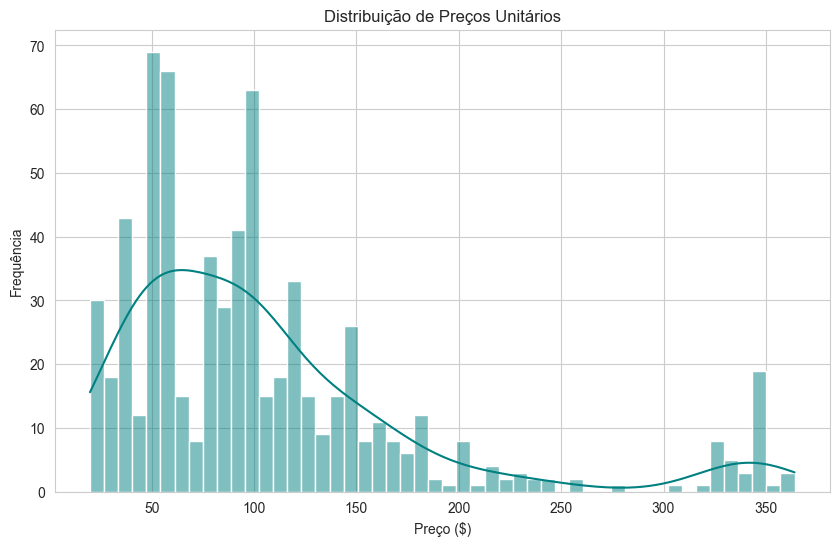

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['unit_price'], bins=50, kde=True, color='teal')
plt.title('Distribuição de Preços Unitários')
plt.xlabel('Preço ($)')
plt.ylabel('Frequência')
plt.show()

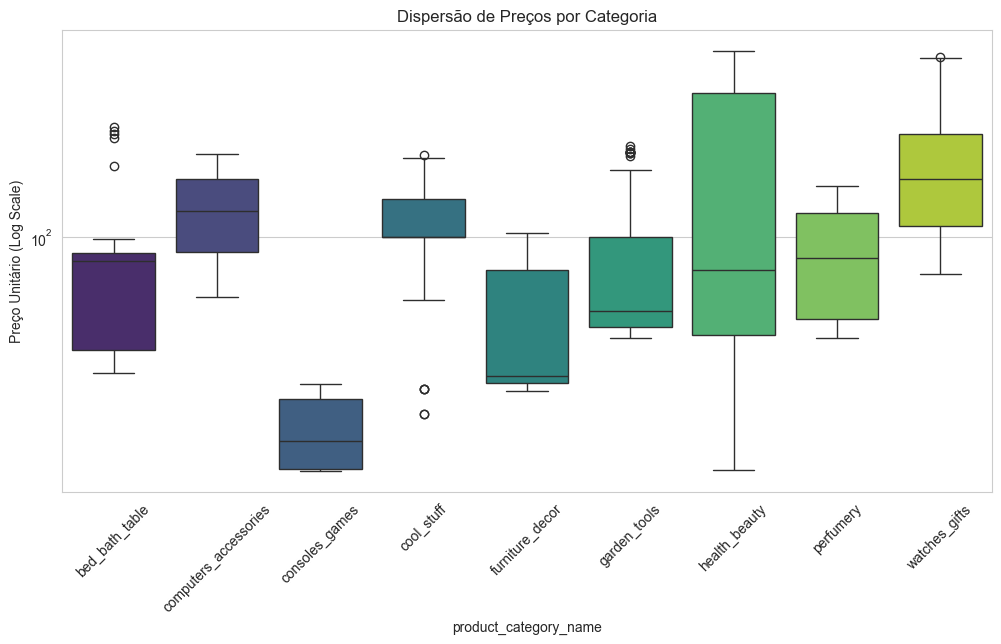

In [10]:
# Boxplot de Preço por Categoria
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='product_category_name', y='unit_price', palette='viridis')
plt.title('Dispersão de Preços por Categoria')
plt.xticks(rotation=45)
plt.yscale('log') # Escala Log para visualizar melhor a diferença
plt.ylabel('Preço Unitário (Log Scale)')
plt.show()

## 5. Conclusão da Análise Descritiva
Esta visão geral nos permite identificar:
- Os produtos "Geração de Caixa" (Top Sellers).
- A sazonalidade do negócio.
- As categorias com maior ticket médio.

**Próximo Passo:** No notebook `03_eda_elasticity`, aprofundaremos na relação Preço x Demanda (Elasticidade) e Decomposição de Séries Temporais para o produto principal.